In [1]:
import numpy as np
import control as ct
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import scienceplots

#Exibição dos gráficos em janela externa:
#%matplotlib qt

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 16 
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Definição dos filtros passa-baixa de Butterworth:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a

def LPF(data, cutoff, fs=1e3, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

<h1 align='center'>Resposta do sistema ao PRBS:<h1>

In [3]:
#Importando os dados:
data = np.loadtxt('prbs30.txt')

#Decupagem e ajuste dos dados:
data = [data[:, 0]-data[:, 0][0], data[:, 1], data[:, 2], data[:, 3]]   #tempo, theta, ref, usig

#Ponto de operação do sistema:
pop = 50

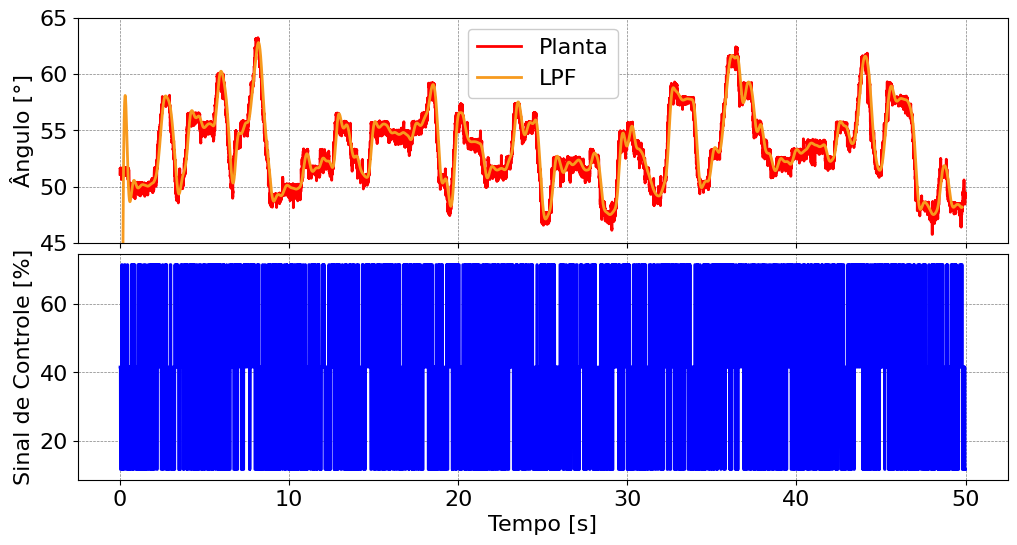

In [11]:
plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.05)
plt.subplot(2, 1, 1)
plt.plot(data[0], data[1], color='r', label='Planta')
plt.plot(data[0][200:]-0.2, LPF(data[1], 2)[200:], color='C4', label='LPF')
plt.ylim(pop-5, pop+15)
plt.ylabel('Ângulo [°]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data[0], data[3], color='b')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

<h1 align='center'>Convolução:<h1>

In [ ]:
#Ordem desejada para o modelo:
n = 1000

#Seleção apenas do regime permanente:
uc = u[int(tdeg/ts):]
yc = y[int(tdeg/ts):]

#Preenchimento da matriz U:
U = []
for k in range(n, len(uc)):
    U.append(np.flip(uc[k-n:k]))
U = np.array(U)

#Criação do vetor Y:
Y = yc[n:].T

#Obtenção dos coeficientes (matriz H) por Estimador de Mínimos Quadrados:
H = np.linalg.inv(U.T@U)@U.T@Y

In [ ]:
#Criação de outro prbs para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, ueq+(getPRBS(ts, tau, tf)*3)))
tvalid = np.arange(0, tf+(tdeg*1e-3), ts*1e-3)

#Simulação do modelo de convolução:
#Preenchimento da matriz U:
Uvalid = []
for k in range(n, len(uvalid)):
    Uvalid.append(np.flip(uvalid[k-n:k]))
Uvalid = np.array(Uvalid)
#Saída do modelo:
yconv = Uvalid@H

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts)+n:]-int((int(tdeg/ts)+n)*1e-3)
uvalid = uvalid[int(tdeg/ts)+n:]
yplanta = yplanta[int(tdeg/ts)+n:]
yconv = yconv[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yconv, color='C1', label='Convolução')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

In [ ]:
#Criação de degraus para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, np.ones(int(tdeg/ts))*(ueq+10), np.ones(int(tdeg/ts))*(ueq-5), np.ones(int(tdeg/ts))*(ueq+5), np.ones(int(tdeg/ts))*(ueq-10)))
tvalid = np.arange(0, int(5*tdeg*1e-3), ts*1e-3)

#Simulação do modelo de convolução:
#Preenchimento da matriz U:
Uvalid = []
for k in range(n, len(uvalid)):
    Uvalid.append(np.flip(uvalid[k-n:k]))
Uvalid = np.array(Uvalid)
#Saída do modelo:
yconv = Uvalid@H

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts)+n:]-int((int(tdeg/ts)+n)*1e-3)
uvalid = uvalid[int(tdeg/ts)+n:]
yplanta = yplanta[int(tdeg/ts)+n:]
yconv = yconv[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yconv, color='C1', label='Convolução')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

<h1 align='center'>ARX:<h1>

In [ ]:
#Seleção apenas do regime permanente:
ua = u[int(tdeg/ts):]
ya = y[int(tdeg/ts):]

#Criação da matriz de estimadores psi:
PSI = []
for k in range(n, len(ua)):
    PSI.append(np.hstack((np.flip(ya[k-n:k-1]), np.flip(ua[k-n:k]))))
PSI = np.array(PSI)

#Obtenção dos coeficientes (matriz theta) por Estimador de Mínimos Quadrados:
THETA = np.linalg.inv(PSI.T@PSI)@PSI.T@Y

In [ ]:
#Criação outro prbs para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, ueq+(getPRBS(ts, tau, tf)*3)))
tvalid = np.arange(0, tf+(tdeg*1e-3), ts*1e-3)

#Simulação do modelo ARX:
yarx = np.ones(n)*pop
for k in range(n, len(uvalid)):
    psi = np.hstack((np.flip(yarx[k-n:k-1]), np.flip(uvalid[k-n:k])))
    yk = psi@THETA
    yarx = np.append(yarx, yk)

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts):]-int((int(tdeg/ts))*1e-3)
uvalid = uvalid[int(tdeg/ts):]
yplanta = yplanta[int(tdeg/ts):]
yarx = yarx[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yarx, color='C1', label='ARX')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

In [ ]:
#Criação de degraus para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, np.ones(int(tdeg/ts))*(ueq+10), np.ones(int(tdeg/ts))*(ueq-5), np.ones(int(tdeg/ts))*(ueq+5), np.ones(int(tdeg/ts))*(ueq-10)))
tvalid = np.arange(0, int(5*tdeg*1e-3), ts*1e-3)

#Simulação do modelo ARX:
yarx = np.ones(n)*pop
for k in range(n, len(uvalid)):
    psi = np.hstack((np.flip(yarx[k-n:k-1]), np.flip(uvalid[k-n:k])))
    yk = psi@THETA
    yarx = np.append(yarx, yk)

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts):]-int((int(tdeg/ts))*1e-3)
uvalid = uvalid[int(tdeg/ts):]
yplanta = yplanta[int(tdeg/ts):]
yarx = yarx[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yarx, color='C1', label='ARX')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()